In [2]:
import os
import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import math
import PAMI
import umap
%matplotlib inline
os.chdir('D://DMLab1//DM2024-Lab1-Master') 
import helpers.data_mining_helpers as dmh

%load_ext autoreload
%autoreload 2

from datasets import load_dataset

ds = load_dataset("Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data")

Data preparation

In [3]:
print(ds["train"][0])
dsTrain = ds["train"]
print(dsTrain.features)
ds_shuffled = dsTrain.shuffle(seed=42)

{'sentiment': 'not nostalgia', 'comment': 'He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.'}
{'sentiment': Value(dtype='string', id=None), 'comment': Value(dtype='string', id=None)}


Data transformation

In [5]:
sentiments = [x.as_py() for x in dsTrain.data['sentiment']]
comments = [x.as_py() for x in dsTrain.data['comment']]
analysis = pd.DataFrame(sentiments, columns=["sentiment"])
type(analysis)

pandas.core.frame.DataFrame

### Fourth: 
In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent
parts you noticed? How can you improve the Data preprocessing for these specific datasets?  
  
Ans:  
不效率的部分我認為可以直接針對dataframe中的欄位進行處理後直接儲存到原本的欄位，不需要另外移出進行處理，不只方便，格式上也可以維持dataframe的形式，更加簡潔。  
而前處理的部分，因為comment是文字資料，可以再多加入一些步驟讓文字處理上更完善有效，例如將字母統一轉換為小寫，加入停用詞移除的處理以及lemmatization, stemming，讓整體文字只留下最簡潔、最具有代表詞義的部分。

### Exercise 1

In [117]:
for t in analysis.comment[:3]:
    print(t)

He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.
The mist beautiful voice ever I listened to him when I was a kid and still love his singing Never forgotten The voice of an angel
I have most of Mr. Reeves songs.  Always love his smooth voice, so comforting and sounds like the people I grew up around.  They were so gentle and sweet, but I had to leave my little town to find a job at age 17.  I graduated early.  I never forgot how great it was to grow up with simple people who had no pretensions -- just loving and gentle, like I think Jesus is.


In [6]:
analysis["comment"] = comments
print(analysis[:5])

       sentiment                                            comment
0  not nostalgia  He was a singer with a golden voice that I lov...
1      nostalgia  The mist beautiful voice ever I listened to hi...
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4      nostalgia  listening to his songs reminds me of my mum wh...


In [7]:
analysis[:5][["sentiment", "comment"]]

,sentiment,comment
0,not nostalgia,He was a singer with a golden voice that I lov...
1,nostalgia,The mist beautiful voice ever I listened to hi...
2,nostalgia,I have most of Mr. Reeves songs. Always love ...
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...
4,nostalgia,listening to his songs reminds me of my mum wh...


In [8]:
analysis.iloc[:5, 1]

0    He was a singer with a golden voice that I lov...
1    The mist beautiful voice ever I listened to hi...
2    I have most of Mr. Reeves songs.  Always love ...
3    30 day leave from 1st tour in Viet Nam to conv...
4    listening to his songs reminds me of my mum wh...
Name: comment, dtype: object

In [9]:
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [10]:
dummySeries = pd.Series(["dummyRecord", 1], ["sentiment", "comment"]) 
dummySeries

sentiment    dummyRecord
comment                1
dtype: object

In [16]:
dummySeries.to_frame().T

,sentiment,comment
0,dummyRecord,1


In [12]:
dummyAnalysis = pd.concat([analysis, dummySeries.to_frame().T], ignore_index=True)
len(dummyAnalysis)

1501

In [13]:
dummyDict = [{'comment': 'dummy_record'}]
analysis = pd.concat([analysis, pd.DataFrame(dummyDict)], ignore_index=True)
len(analysis)

1501

In [14]:
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,1,0


### Exercise 4

In [121]:
analysis.isnull().apply(lambda x: dmh.check_missing_values(x), axis=1)

0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
1495    (The amoung of missing records is: , 0)
1496    (The amoung of missing records is: , 0)
1497    (The amoung of missing records is: , 0)
1498    (The amoung of missing records is: , 0)
1499    (The amoung of missing records is: , 0)
Length: 1498, dtype: object

In [15]:
analysis.dropna(inplace=True)
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [17]:
analysis.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Length: 1500, dtype: bool

In [18]:
ttl = sum(analysis.duplicated())
cm = sum(analysis.duplicated("comment"))
print("ttl: ", ttl, "comment: ", cm)

ttl:  1 comment:  1


In [19]:
analysis.drop_duplicates(keep=False, inplace=True)
len(analysis)

1498

Data preprocessing

In [20]:
analysisSample = analysis.sample(n = 1000)
len(analysisSample)

1000

In [21]:
analysisSample[:5]

,sentiment,comment
1039,not nostalgia,"I don't even dare listening to the music, just..."
329,not nostalgia,they don't make rock stars like they used to n...
689,nostalgia,This is a beautiful video with a great song. S...
856,nostalgia,I can still remember the day I first heard thi...
141,nostalgia,I was on my way to San Francisco what a time t...


category
1    750
2    748
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='sentiment'>

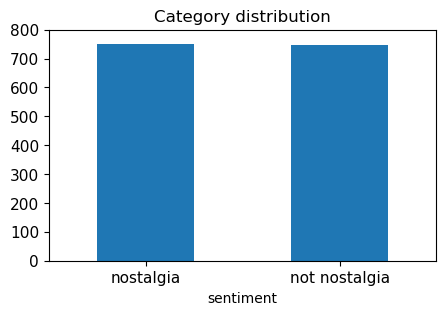

In [109]:
print(analysis.category.value_counts())
analysis.sentiment.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 800],        
                                    rot = 0, fontsize = 11, figsize = (5,3))

sentiment
nostalgia        506
not nostalgia    494
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='sentiment'>

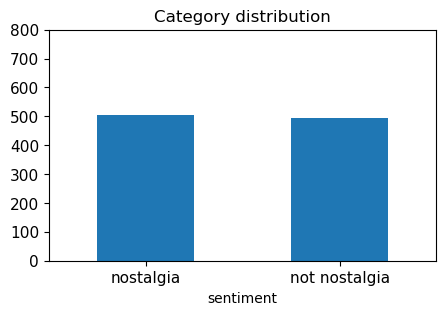

In [23]:
print(analysisSample.sentiment.value_counts())
analysisSample.sentiment.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 800],        
                                    rot = 0, fontsize = 11, figsize = (5,3))

### Exercise 6
ans:  
The distribution of sample data might differ from the original one. And the data distribution or missing value distribution might differ from the original one.

### Exercise 7

<Axes: title={'center': 'Category distribution'}, xlabel='sentiment'>

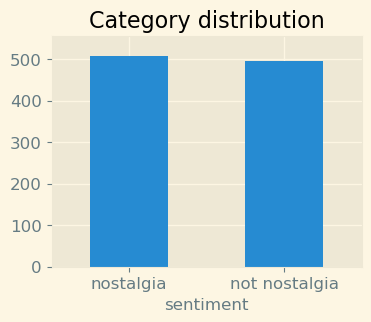

In [123]:
upper_bound = max(analysisSample.sentiment.value_counts() + 50)

plt.style.use("Solarize_Light2")
# plot barchart for X_sample
analysisSample.sentiment.value_counts().plot(kind = 'bar',
                                           title = 'Category distribution',
                                           ylim = [0, upper_bound], 
                                           rot = 0, fontsize = 12, figsize = (4,3))

### Exercise 8

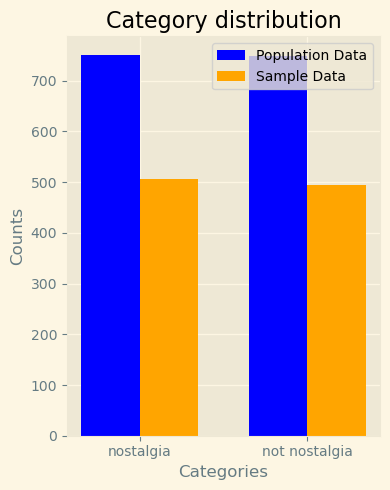

In [125]:
analysis_counts = analysis.sentiment.value_counts()
analysis_sample_counts = analysisSample.sentiment.value_counts()

categories = ['nostalgia', 'not nostalgia']

analysis_counts = analysis_counts.reindex(categories).fillna(0)
analysis_sample_counts = analysis_sample_counts.reindex(categories).fillna(0)

bar_width = 0.35
index = np.arange(len(categories))

plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(figsize=(4, 5))

bar1 = ax.bar(index, analysis_counts, bar_width, label='Population Data', color='blue')

bar2 = ax.bar(index + bar_width, analysis_sample_counts, bar_width, label='Sample Data', color='orange')

ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title('Category distribution')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)

ax.legend()

plt.tight_layout()
plt.show()

In [25]:
analysis["unigrams"] = analysis["comment"].apply(lambda x: dmh.tokenize_text(x))
analysis[:5]["unigrams"]

0    [He, was, a, singer, with, a, golden, voice, t...
1    [The, mist, beautiful, voice, ever, I, listene...
2    [I, have, most, of, Mr., Reeves, songs, ., Alw...
3    [30, day, leave, from, 1st, tour, in, Viet, Na...
4    [listening, to, his, songs, reminds, me, of, m...
Name: unigrams, dtype: object

In [26]:
analysis[:5]

,sentiment,comment,unigrams
0,not nostalgia,He was a singer with a golden voice that I lov...,"[He, was, a, singer, with, a, golden, voice, t..."
1,nostalgia,The mist beautiful voice ever I listened to hi...,"[The, mist, beautiful, voice, ever, I, listene..."
2,nostalgia,I have most of Mr. Reeves songs. Always love ...,"[I, have, most, of, Mr., Reeves, songs, ., Alw..."
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...,"[30, day, leave, from, 1st, tour, in, Viet, Na..."
4,nostalgia,listening to his songs reminds me of my mum wh...,"[listening, to, his, songs, reminds, me, of, m..."


In [111]:
sentiment_number = {'nostalgia': 1, 'not nostalgia':2}
analysis['category'] = analysis['sentiment'].map(sentiment_number)

In [108]:
analysis[:5]

,sentiment,comment,unigrams,tokenized_comment,category
0,not nostalgia,He was a singer with a golden voice that I lov...,"[He, was, a, singer, with, a, golden, voice, t...","{you, emotional, now,, but,, voice, in, age, c...",2
1,nostalgia,The mist beautiful voice ever I listened to hi...,"[The, mist, beautiful, voice, ever, I, listene...","{voice, was, angel, Never, listened, beautiful...",1
2,nostalgia,I have most of Mr. Reeves songs. Always love ...,"[I, have, most, of, Mr., Reeves, songs, ., Alw...","{smooth, simple, age, at, grew, was, it, grow,...",1
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...,"[30, day, leave, from, 1st, tour, in, Viet, Na...","{years, receive., you, Lou., the, served, can,...",2
4,nostalgia,listening to his songs reminds me of my mum wh...,"[listening, to, his, songs, reminds, me, of, m...","{played, him, listening, reminds, everyday, so...",1


### Exercise 2

In [119]:
result = analysis.query('category > 1')
print(result[:3])

       sentiment                                            comment  \
0  not nostalgia  He was a singer with a golden voice that I lov...   
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...   
8  not nostalgia           Wherever you  are you always in my heart   

                                            unigrams  \
0  [He, was, a, singer, with, a, golden, voice, t...   
3  [30, day, leave, from, 1st, tour, in, Viet, Na...   
8   [Wherever, you, are, you, always, in, my, heart]   

                                   tokenized_comment  category  
0  {you, emotional, now,, but,, voice, in, age, c...         2  
3  {years, receive., you, Lou., the, served, can,...         2  
8        {are, you, always, Wherever, heart, in, my}         2  


### Exercise 3

In [120]:
print(analysis[analysis["sentiment"] == "nostalgia"].iloc[::10][:5])

    sentiment                                            comment  \
1   nostalgia  The mist beautiful voice ever I listened to hi...   
18  nostalgia  My Grandparents had a pub in the 1970's, this ...   
32  nostalgia  I remember my Mom listening to Jim over and ov...   
50  nostalgia  If I remember correctly, this song came out af...   
71  nostalgia  Gosh does this bring back memories. Nearly eve...   

                                             unigrams  \
1   [The, mist, beautiful, voice, ever, I, listene...   
18  [My, Grandparents, had, a, pub, in, the, 1970,...   
32  [I, remember, my, Mom, listening, to, Jim, ove...   
50  [If, I, remember, correctly, ,, this, song, ca...   
71  [Gosh, does, this, bring, back, memories, ., N...   

                                    tokenized_comment  category  
1   {voice, was, angel, Never, listened, beautiful...         1  
18  {makes, time, My, in, 1970's,, was, wonderful,...         1  
32  {you, remember, memories, over, miss, Mom, chi

In [28]:
count_vect = CountVectorizer()
analysisCounts = count_vect.fit_transform(analysis.comment)
print(analysisCounts[0])

  (0, 1598)	1
  (0, 3570)	2
  (0, 2973)	1
  (0, 3650)	1
  (0, 1470)	1
  (0, 3534)	1
  (0, 3282)	1
  (0, 2028)	1
  (0, 3336)	1
  (0, 1606)	1
  (0, 233)	2
  (0, 3284)	3
  (0, 3328)	2
  (0, 1651)	2
  (0, 1512)	1
  (0, 1249)	1
  (0, 323)	1
  (0, 214)	1
  (0, 2341)	1
  (0, 15)	1
  (0, 1733)	1
  (0, 3304)	1
  (0, 907)	1
  (0, 258)	2
  (0, 3124)	1
  (0, 2328)	2
  (0, 245)	1
  (0, 3581)	1
  (0, 1591)	1
  (0, 2082)	1
  (0, 2974)	1
  (0, 573)	1
  (0, 593)	1
  (0, 3538)	1
  (0, 1347)	2
  (0, 1833)	1
  (0, 2671)	1
  (0, 3713)	2
  (0, 1272)	1
  (0, 2688)	1
  (0, 1125)	1
  (0, 2035)	1
  (0, 3278)	1
  (0, 2018)	1
  (0, 1964)	1


In [29]:
count_vect.get_feature_names_out()[1606]

'hear'

In [30]:
textAnalyze =  count_vect.build_analyzer()
textAnalyze("I am craving for a hawaiian pizza right now")

['am', 'craving', 'for', 'hawaiian', 'pizza', 'right', 'now']

In [31]:
test = "\n".join(analysis["unigrams"][0])
print(test)

He
was
a
singer
with
a
golden
voice
that
I
love
to
hear
all
the
time
.
I
was
his
great
fan
at
the
age
of
16years
in
those
days
and
still
now
.
Although
we
have
many
singers
now
,
but
,
I
can
vouch
for
Jim
Reeves
all
the
time
.
You
feel
relaxed
,
emotional
and
loving
.
Thank
you
Lord
for
his
life
.


In [32]:
textAnalyze(test)

['he',
 'was',
 'singer',
 'with',
 'golden',
 'voice',
 'that',
 'love',
 'to',
 'hear',
 'all',
 'the',
 'time',
 'was',
 'his',
 'great',
 'fan',
 'at',
 'the',
 'age',
 'of',
 '16years',
 'in',
 'those',
 'days',
 'and',
 'still',
 'now',
 'although',
 'we',
 'have',
 'many',
 'singers',
 'now',
 'but',
 'can',
 'vouch',
 'for',
 'jim',
 'reeves',
 'all',
 'the',
 'time',
 'you',
 'feel',
 'relaxed',
 'emotional',
 'and',
 'loving',
 'thank',
 'you',
 'lord',
 'for',
 'his',
 'life']

### Exercise 9

In [127]:
analyze = count_vect.build_analyzer()
analyze(analysis.comment[0])

['he',
 'was',
 'singer',
 'with',
 'golden',
 'voice',
 'that',
 'love',
 'to',
 'hear',
 'all',
 'the',
 'time',
 'was',
 'his',
 'great',
 'fan',
 'at',
 'the',
 'age',
 'of',
 '16years',
 'in',
 'those',
 'days',
 'and',
 'still',
 'now',
 'although',
 'we',
 'have',
 'many',
 'singers',
 'now',
 'but',
 'can',
 'vouch',
 'for',
 'jim',
 'reeves',
 'all',
 'the',
 'time',
 'you',
 'feel',
 'relaxed',
 'emotional',
 'and',
 'loving',
 'thank',
 'you',
 'lord',
 'for',
 'his',
 'life']

In [33]:
count_vect.get_feature_names_out()[600:611]

array(['captial', 'captivating', 'captured', 'car', 'cardiff', 'care',
       'cared', 'carefree', 'careful', 'carefully', 'cares'], dtype=object)

In [34]:
analysisCounts[:5, :100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [35]:
plotX = ["term_" + str(i) for i in count_vect.get_feature_names_out()[:20]]
plotY = ["doc_" + str(i) for i in list(analysis.index)[:20]]
plotZ = analysisCounts[:20, :20].toarray()
plotZ

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

### Exercise 10

In [139]:
count_vect = CountVectorizer()
anaCounts = count_vect.fit_transform(analysis.comment)
dense_matrix = anaCounts[0:5, 0:20].toarray()

feature_names = count_vect.get_feature_names_out()

# my ans:
for doc_index, doc in enumerate(dense_matrix):
    print(f"\n文檔 {doc_index} 的出現詞彙:")
    for word_index, count in enumerate(doc):
        if count > 0:  # 找到矩陣中為 1 的值
            print(f"- {feature_names[word_index]}: 出現 {count} 次")


文檔 0 的出現詞彙:
- 16years: 出現 1 次

文檔 1 的出現詞彙:

文檔 2 的出現詞彙:
- 17: 出現 1 次

文檔 3 的出現詞彙:

文檔 4 的出現詞彙:


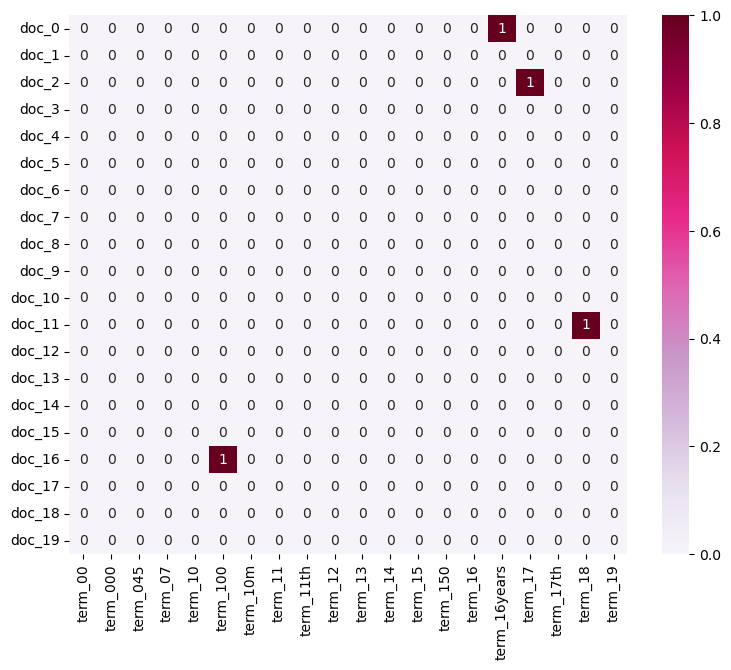

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dfPlot = pd.DataFrame(plotZ, columns = plotX, index = plotY)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(dfPlot,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

### Exercise 11

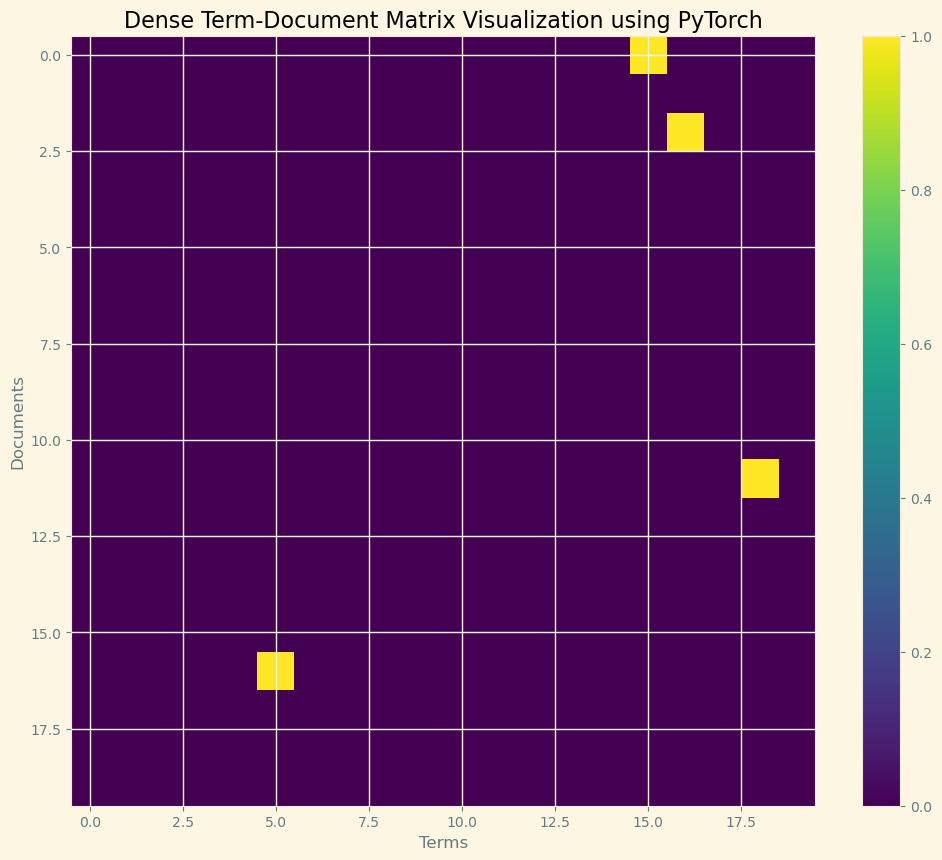

In [136]:
import torch
import numpy as np
from scipy.sparse import csr_matrix

# 假設 sparse_matrix 是一個 SciPy 的稀疏矩陣
sparse_matrix = csr_matrix(plotZ)  # 你的稀疏矩陣資料

# 將 SciPy 稀疏矩陣轉換為 PyTorch 稀疏張量
coo = sparse_matrix.tocoo()  # 轉為 COOrdinate 格式，方便提取 indices 和 values
values = torch.tensor(coo.data, dtype=torch.float32)
indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)
torch_sparse_matrix = torch.sparse.FloatTensor(indices, values, torch.Size(coo.shape))

# 將 PyTorch 稀疏張量轉為密集張量
dense_matrix = torch_sparse_matrix.to_dense()

# 繪製轉換後的密集矩陣
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(dense_matrix.numpy(), cmap="viridis", aspect='auto')
plt.colorbar()
plt.title("Dense Term-Document Matrix Visualization using PyTorch")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

### Exercise 12

In [140]:
import plotly.graph_objects as go

# 聚合屬性 (這裡僅選擇前 300 個詞頻作為範例)
words = count_vect.get_feature_names_out()[:300]
frequencies = term_frequencies[:300]

# 使用 Plotly 繪製條形圖
fig = go.Figure(data=[
    go.Bar(x=words, y=frequencies)
])

# 設定圖形屬性
fig.update_layout(
    title="Term Frequencies (Top 300 Terms)",
    xaxis_title="Terms",
    yaxis_title="Frequency",
    xaxis_tickangle=-90,
    width=1200,  # 調整圖寬以更好地顯示詞語
    height=600
)

# 顯示圖形
fig.show()

### Exercise 13

C:\Users\HP\AppData\Local\Temp\ipykernel_18564\2702429419.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



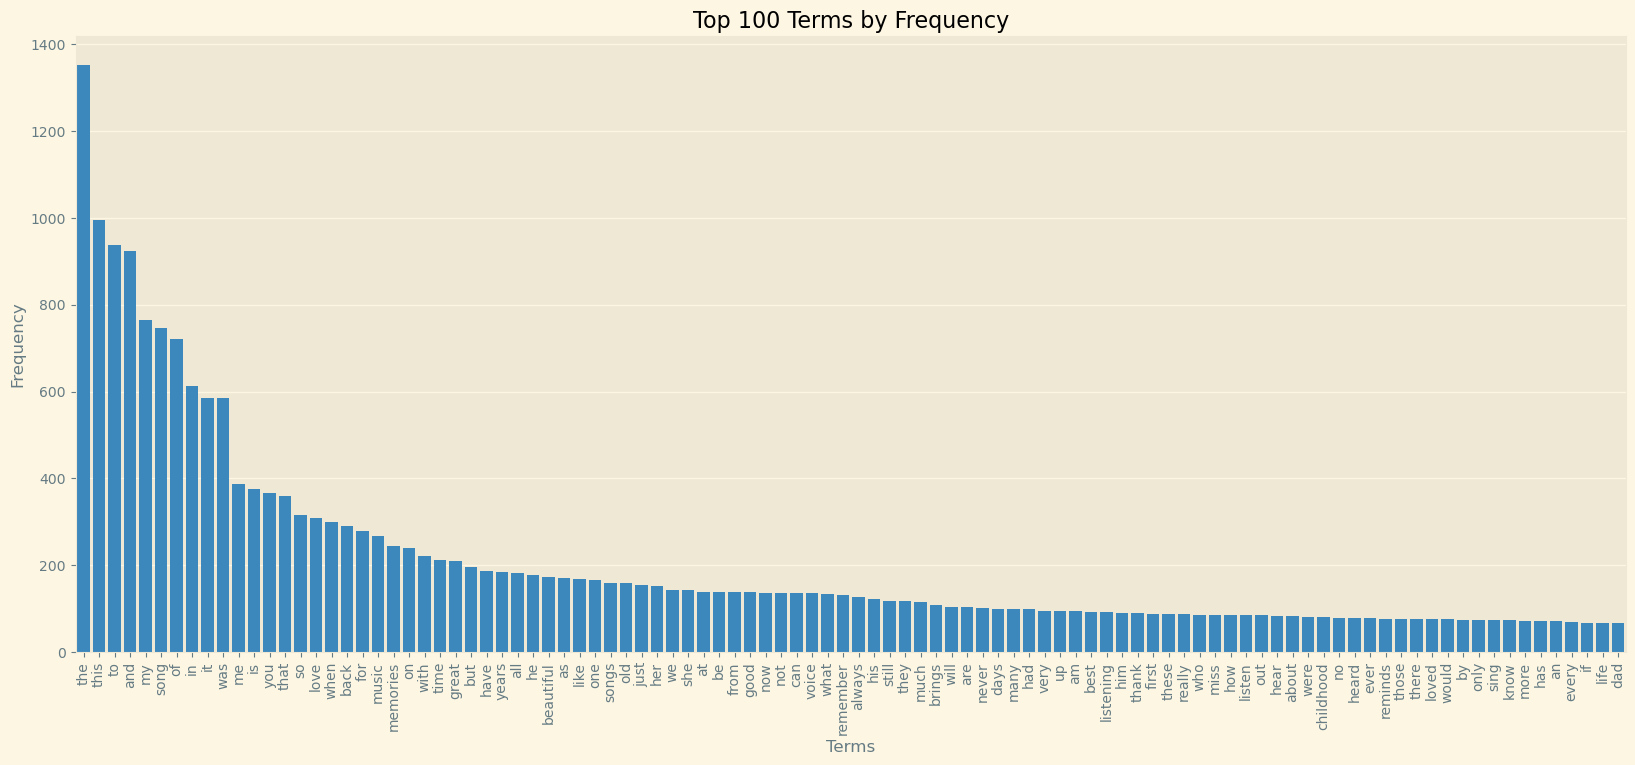

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# 選擇頻次最高的前 100 個詞
top_n = 100
top_indices = term_frequencies.argsort()[-top_n:][::-1]  # 取得頻次最高的索引
top_words = count_vect.get_feature_names_out()[top_indices]
top_frequencies = term_frequencies[top_indices]

# 繪製條形圖
plt.subplots(figsize=(20, 8))  # 調整圖形大小以適應較少的詞數
g = sns.barplot(x=top_words, y=top_frequencies)
g.set_xticklabels(top_words, rotation=90)
plt.title(f"Top {top_n} Terms by Frequency")
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.show()

### Exercise 14

In [142]:
import plotly.graph_objects as go

words = count_vect.get_feature_names_out()[:300]
frequencies = term_frequencies[:300]

# 對詞頻進行降序排序
sorted_indices = np.argsort(frequencies)[::-1]
sorted_words = words[sorted_indices]
sorted_frequencies = frequencies[sorted_indices]

fig = go.Figure(data=[
    go.Bar(x=sorted_words, y=sorted_frequencies)
])

# 設定圖形屬性
fig.update_layout(
    title="Term Frequencies (Top 300 Terms Sorted by Frequency)",
    xaxis_title="Terms",
    yaxis_title="Frequency",
    xaxis_tickangle=-90,
    width=1200,  # 調整圖寬
    height=600
)

fig.show()

### Exercise 15

C:\Users\HP\AppData\Local\Temp\ipykernel_18564\3223303035.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



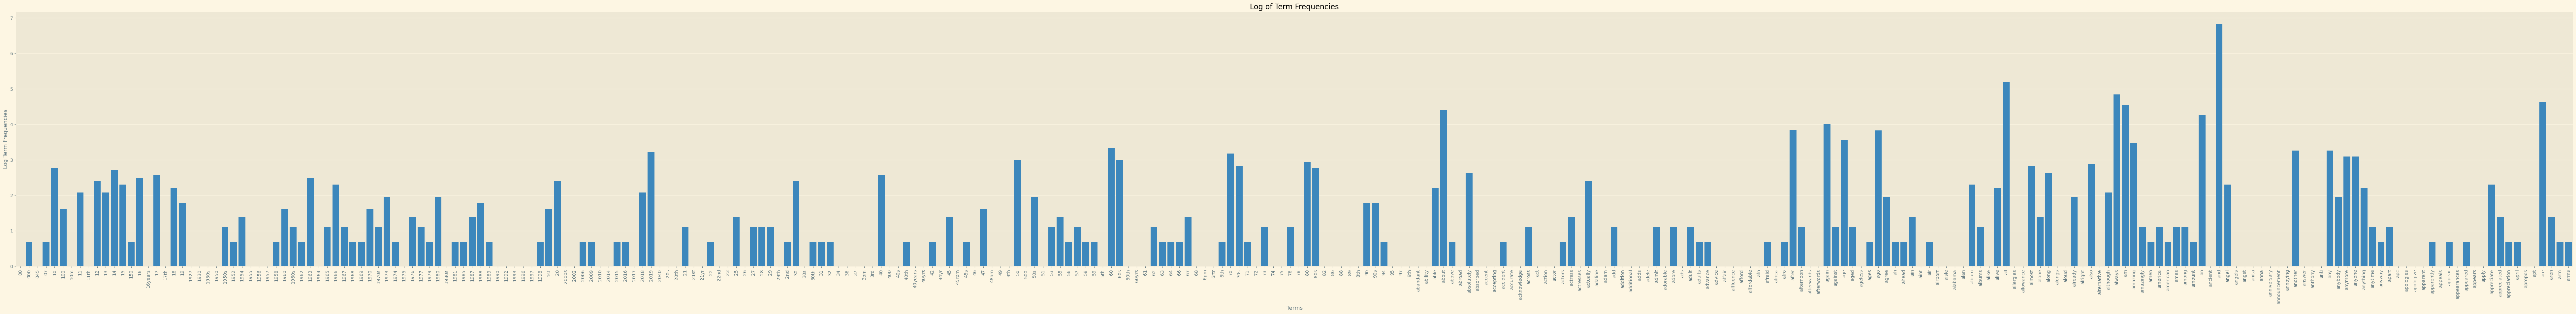

In [143]:
term_frequencies_log = [math.log(i) for i in term_frequencies if i > 0]  # 確保不取 log(0)

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation=90)
plt.title('Log of Term Frequencies')
plt.xlabel('Terms')
plt.ylabel('Log Term Frequencies')
plt.show()

In [38]:
term_frequencies = []
for j in range(0,analysisCounts.shape[1]):
    term_frequencies.append(sum(analysisCounts[:,j].toarray()))

In [39]:
term_frequencies = np.asarray(analysisCounts.sum(axis=0))[0]
print(term_frequencies[4])

16


C:\Users\HP\AppData\Local\Temp\ipykernel_18564\3480579971.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);


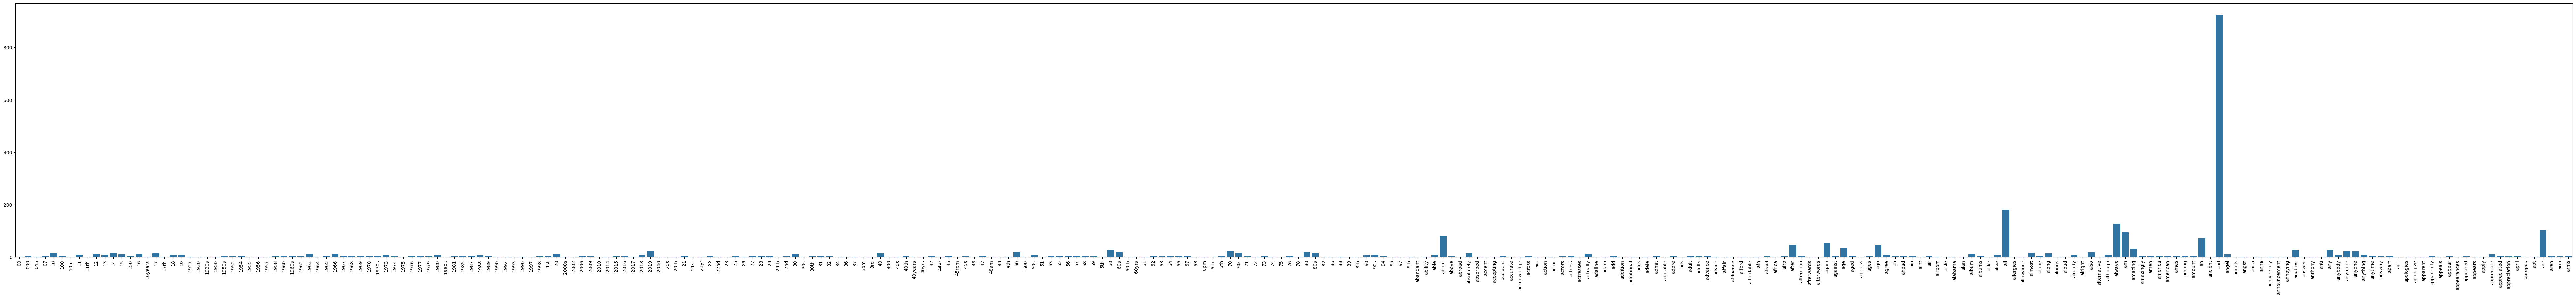

In [40]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

C:\Users\HP\AppData\Local\Temp\ipykernel_18564\1204966152.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);


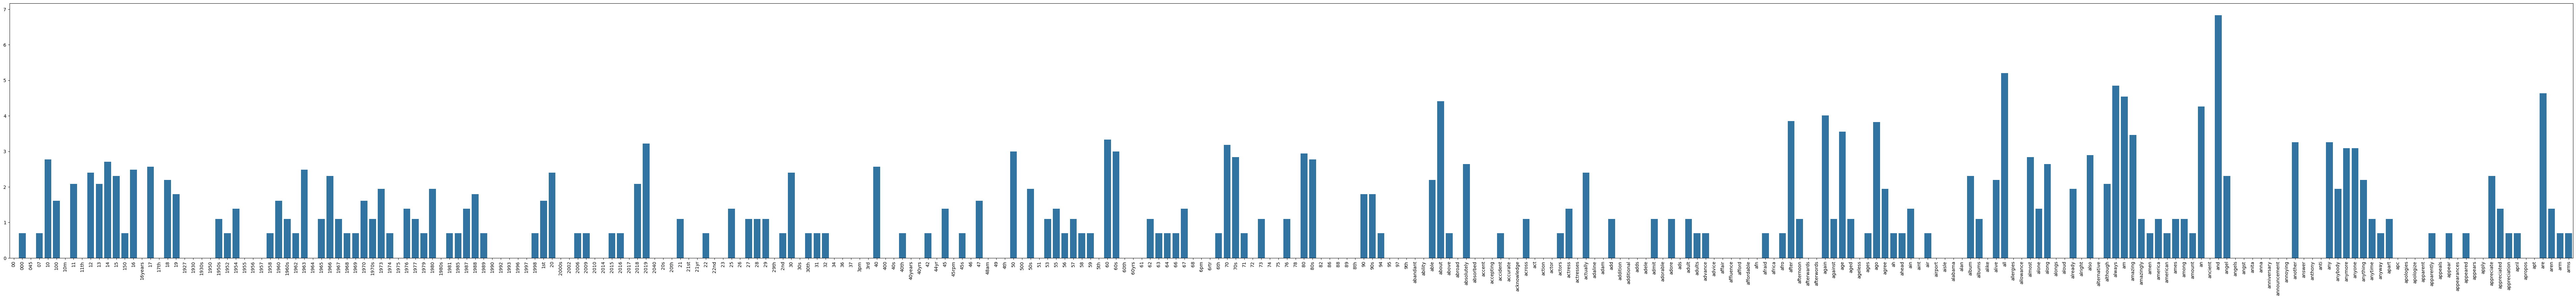

In [41]:
term_frequencies_log = [math.log(i) for i in term_frequencies]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

Feature subset selection

In [110]:
categories = analysis["sentiment"].unique()
category_dfs = {}

for category in categories:
    category_dfs[category] = analysis[analysis["sentiment"] == category].copy()
    
def create_term_document_df(df):
    count_vect = CountVectorizer()
    analysisCounts = count_vect.fit_transform(df["comment"])  
    words = count_vect.get_feature_names_out()
    
    term_document_df = pd.DataFrame(analysisCounts.toarray(), columns=words)
    
    return term_document_df

term_document_dfs = {}

for category in categories:
    term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [43]:
category_number = 1
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category nostalgia:


,07,10,11,11th,12,13,14,15,16,17,...,young,younger,youngster,your,yours,youth,youthful,youtube,yrs,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


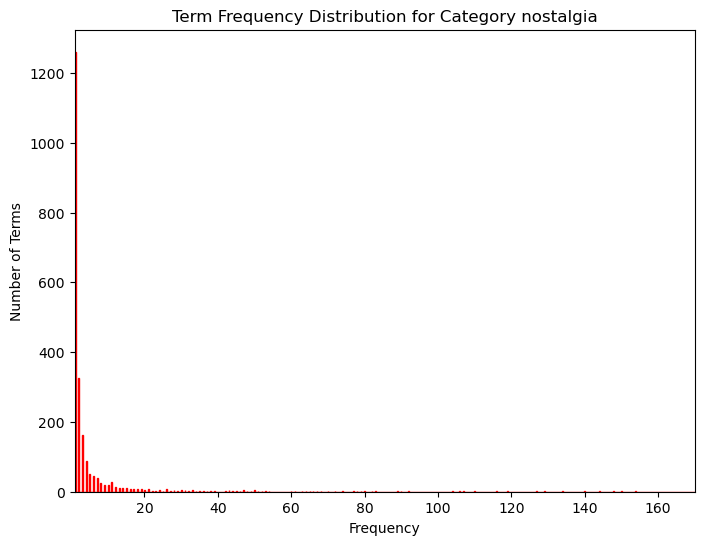

In [44]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
 
# Visualize the frequency distribution
plt.figure(figsize = (8, 6))
plt.hist(word_counts, bins = 3000, color = 'black', edgecolor = 'red')
plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 170)
plt.show()

In [45]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis = 0).to_numpy()

sorted_indices = np.argsort(word_counts)
sorted_counts = np.sort(word_counts)[::-1]

total_terms = len(sorted_counts)
top_5_percent_index = int(0.05 * total_terms)

top_5_percent_indices = sorted_indices[:top_5_percent_index]

filtered_words = [count_vect.get_feature_names_out()[i] for i in top_5_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in top 5%: {top_5_percent_index}")
print(f"Filtered terms: {filtered_words}")

Category: nostalgia
Number of terms in top 5%: 114
Filtered terms: ['nicer', 'dc', 'if', 'ignore', 'ill', 'david', 'illicit', 'im', 'idea', 'images', 'imho', 'imitated', 'immediately', 'impeccable', 'impersonate', 'dark', 'impossible', 'imagine', 'deal', 'dean', 'iconized', 'hum', 'human', 'degrade', 'humming', 'defining', 'hums', 'hurry', 'dedicated', 'declined', 'decide', 'decent', 'decency', 'december', 'husbands', 'decca', 'ibm', 'death', 'danube', 'democrat', 'imprinted', 'danial', 'crying', 'cry', 'insane', 'cruise', 'cruel', 'crown', 'crossroads', 'crystal', 'crossed', 'inspire', 'crescendo', 'instantly', 'instead', 'instinctively', 'instructions', 'created', 'crop', 'cuban', 'innocent', 'cupcakes', 'incase', 'incredibly', 'dancers', 'incurable', 'india', 'damn', 'dairy', 'dads', 'daddy', 'industry', 'influential', 'infomercial', 'curtis', 'inhaling', 'curled', 'curious', 'innocence', 'in', 'hug', 'https', 'depending', 'divine', 'disturbing', 'distraction', 'hit', 'hitler', 'dis

In [46]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

sorted_indices = np.argsort(word_counts) 
sorted_counts = word_counts[sorted_indices] 

total_terms = len(sorted_counts)
bottom_1_percent_index = int(0.01 * total_terms)

bottom_1_percent_indices = sorted_indices[:bottom_1_percent_index]

filtered_words = [count_vect.get_feature_names_out()[i] for i in bottom_1_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in bottom 1%: {bottom_1_percent_index}")
print(f"Filtered terms: {filtered_words}")

Category: nostalgia
Number of terms in bottom 1%: 22
Filtered terms: ['nicer', 'dc', 'if', 'ignore', 'ill', 'david', 'illicit', 'im', 'idea', 'images', 'imho', 'imitated', 'immediately', 'impeccable', 'impersonate', 'dark', 'impossible', 'imagine', 'deal', 'dean', 'iconized', 'hum']


In [47]:
#移除極端情形
category_number = 1

def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    word_sums = term_document_df.sum(axis=0)
    
    sorted_words = word_sums.sort_values()
    
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    
    return term_document_df.drop(columns=words_to_remove)

filtered_term_document_dfs = {}

for category in categories:
    filtered_term_document_dfs[category] = filter_top_bottom_words_by_sum(term_document_dfs[category])
term_document_dfs=filtered_term_document_dfs

print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs[categories[category_number]]

Filtered Term-Document Frequency DataFrame for Category nostalgia:


,07,10,11,11th,12,13,14,15,16,17,...,yo,yokel,younger,youngster,your,yours,youth,youthful,youtube,yrs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exercise 16
Ans:  
差異:相較於沒有經過filtered的資料，經過filtered後一些較不具意義的字詞會被篩選掉  
相似: 其整體結構仍然相似，被保留下來的詞彙很可能是核心詞彙

In [54]:
# from PAMI.extras.DF2DB import DenseFormatDF as db
from PAMI.extras.convert.DF2DB import DF2DB

for category in term_document_dfs:

    category_safe = category.replace('.', '_')

    print(category_safe)
    
    obj = DF2DB(term_document_dfs[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}.csv', '>=', 1)

not nostalgia
nostalgia


Database size (total no of transactions) : 734
Number of items : 2159
Minimum Transaction Size : 1
Average Transaction Size : 8.693460490463215
Maximum Transaction Size : 39
Standard Deviation Transaction Size : 7.213372063492091
Variance in Transaction Sizes : 52.10372252435774
Sparsity : 0.9959733855996001


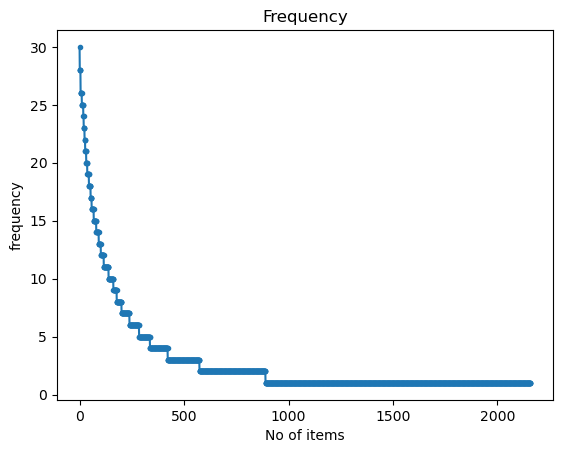

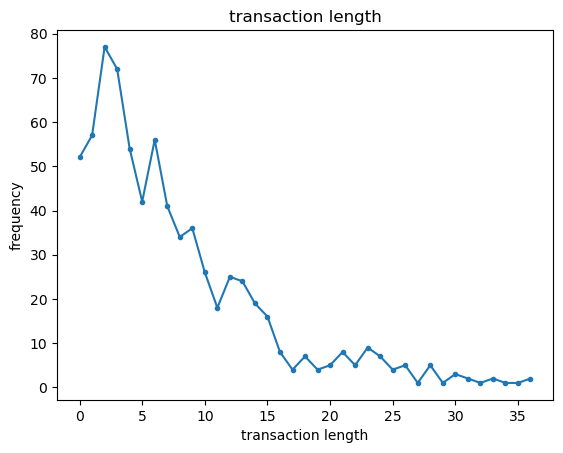

In [55]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 744
Number of items : 2446
Minimum Transaction Size : 1
Average Transaction Size : 8.416666666666666
Maximum Transaction Size : 46
Standard Deviation Transaction Size : 5.952413594380544
Variance in Transaction Sizes : 35.47891431135038
Sparsity : 0.996559007904061


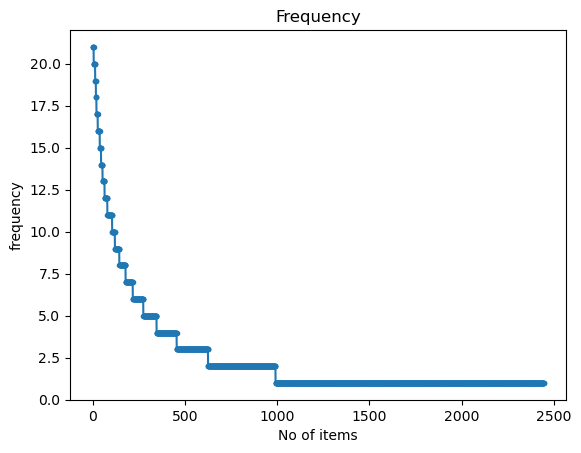

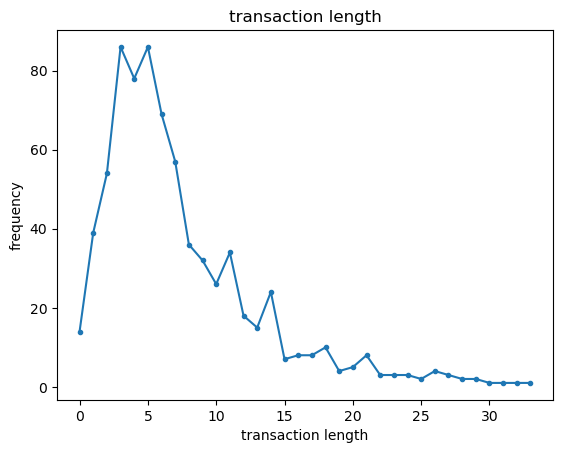

In [56]:
obj = tds.TransactionalDatabase('td_freq_db_not nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [57]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup = 5
obj1 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup = minSup)
obj1.mine()
frequentPatternsDF_notNostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_notNostalgia))) 
print('Runtime: ' + str(obj1.getRuntime()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 355
Runtime: 0.10848546028137207


In [58]:
minSup = 6
obj1 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup = minSup)
obj1.mine()
frequentPatternsDF_nostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) 
print('Runtime: ' + str(obj1.getRuntime()))

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
Total No of patterns: 301
Runtime: 0.2181541919708252


In [59]:
obj1.save('freq_patterns_notNostalgia_minSup9.txt')
frequentPatternsDF_notNostalgia

,Patterns,Support
0,leave,5
1,number,5
2,father,5
3,remember,5
4,100,5
...,...,...
350,elvis,21
351,every,21
352,loved,21
353,them,21


In [60]:
obj1.save('freq_patterns_nostalgia_minSup9.txt')
frequentPatternsDF_nostalgia

,Patterns,Support
0,grow,6
1,sounds,6
2,reminded,6
3,18,6
4,album,6
...,...,...
296,ever,28
297,would,28
298,will,28
299,go,28


In [61]:
dfs = [frequentPatternsDF_notNostalgia, frequentPatternsDF_nostalgia]

pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}

total_patterns_count = sum(len(df) for df in dfs)

discarded_patterns_count = total_patterns_count - len(unique_patterns)

filtered_dfs = []

for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

print(final_pattern_df)

print(f"Number of patterns discarded: {discarded_patterns_count}")

     Patterns  Support
365      will       28
364     would       28
363      ever       28
361      wish       26
360        or       26
..        ...      ...
34       door        5
33        bit        5
32   vocalist        5
31     making        5
0       leave        5

[366 rows x 2 columns]
Number of patterns discarded: 290


In [62]:
count_vect = CountVectorizer()

analysis_tdm = count_vect.fit_transform(analysis["comment"])
terms = count_vect.get_feature_names_out()

analysis['tokenized_comment'] = analysis["comment"].str.split().apply(set)

pattern_matrix = pd.DataFrame(0, index = analysis.index, columns = final_pattern_df['Patterns'])

for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())
    pattern_matrix[pattern] = analysis['tokenized_comment'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

tdm_df = pd.DataFrame(analysis_tdm.toarray(), columns = terms, index = analysis.index)

augmented_df = pd.concat([tdm_df, pattern_matrix], axis = 1)
augmented_df

,00,000,045,07,10,100,10m,11,11th,12,...,touching,behind,anything,two,totally,door,bit,vocalist,making,leave
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

ana_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
ana_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
ana_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

In [65]:
ana_pca_tdm.shape

(1498, 2)

In [66]:
ana_tsne_tdm.shape

(1498, 2)

In [67]:
ana_umap_tdm.shape

(1498, 2)

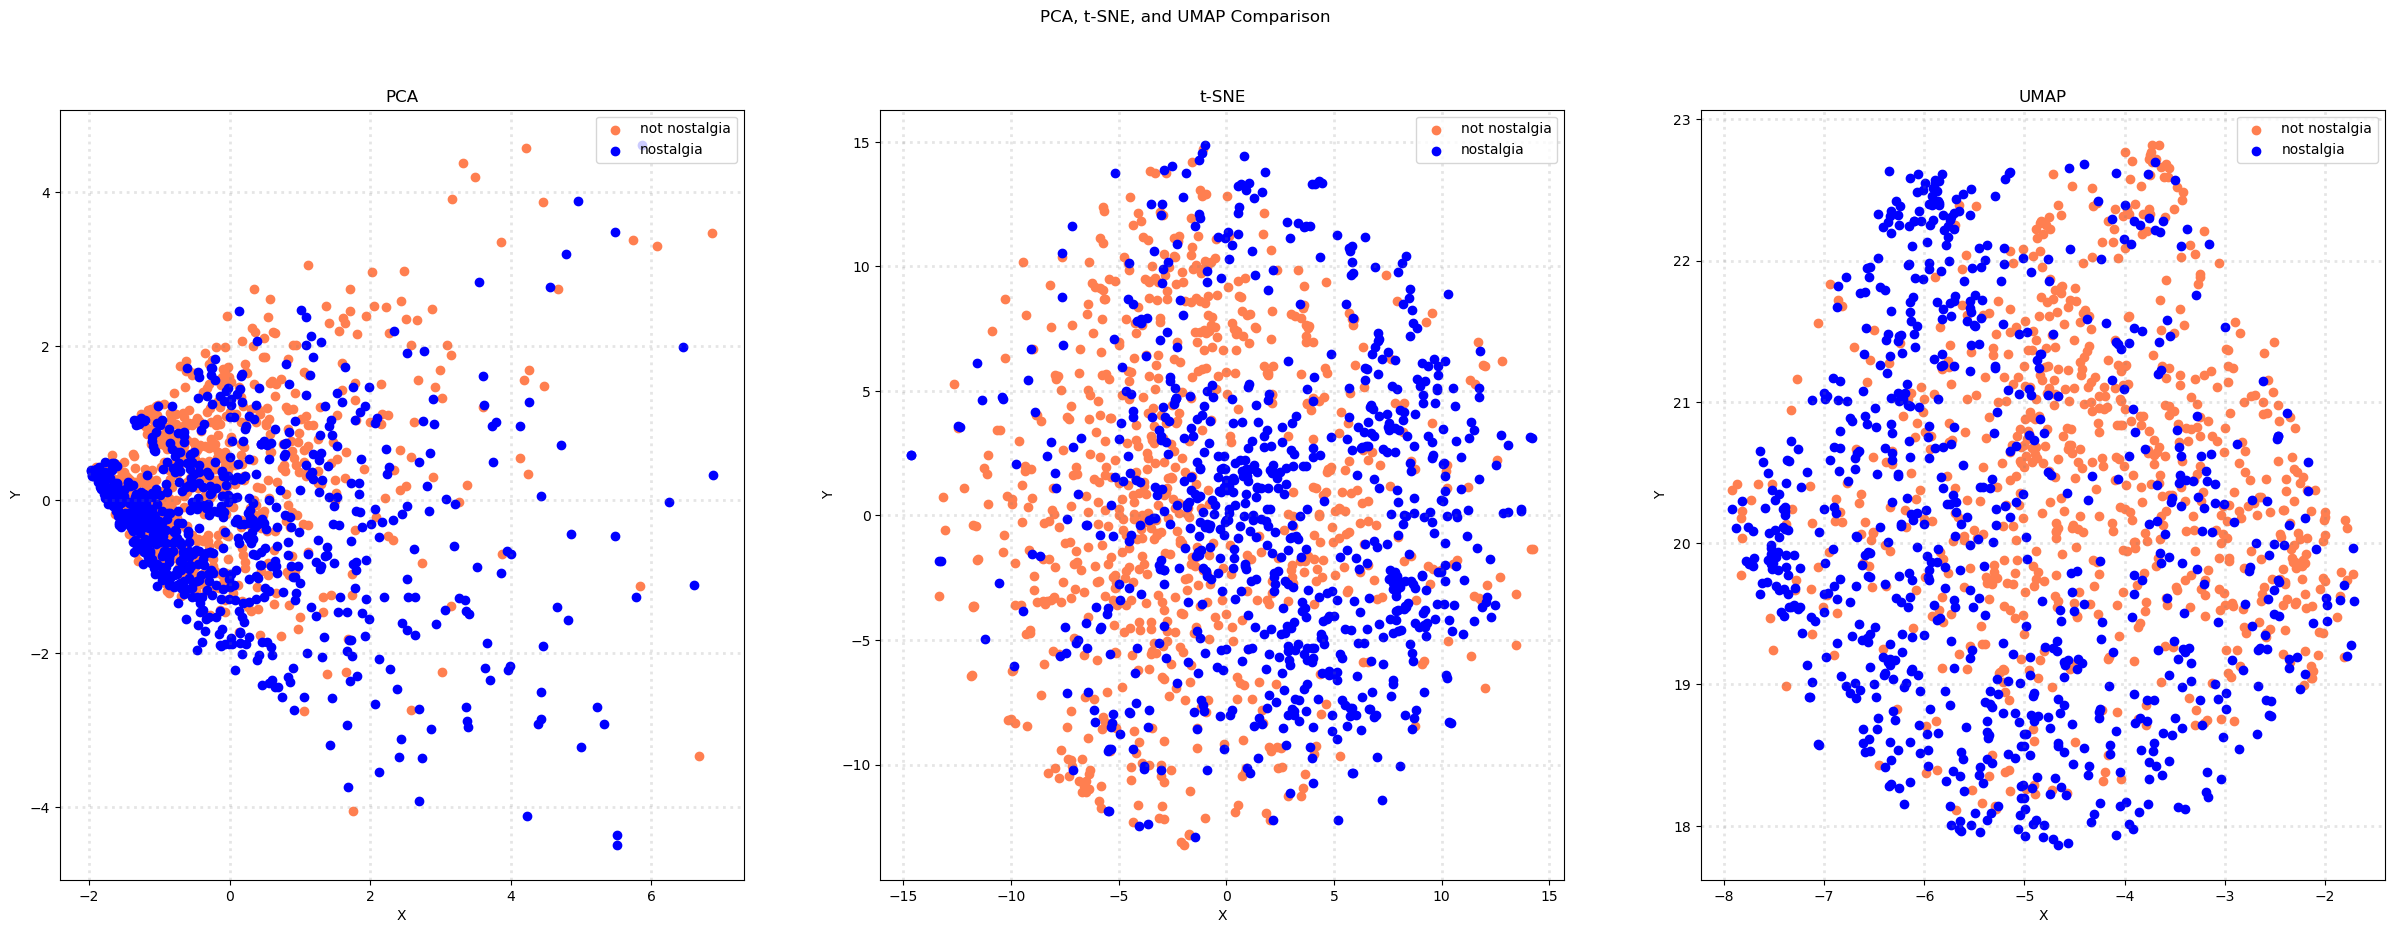

In [68]:
col = ['coral', 'blue']
categories = analysis['sentiment'].unique() 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

def plot_scatter(ax, ana_reduced, title):
    for c, category in zip(col, categories):
        xs = ana_reduced[analysis['sentiment'] == category].T[0]
        ys = ana_reduced[analysis['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], ana_pca_tdm, 'PCA')
plot_scatter(axes[1], ana_tsne_tdm, 't-SNE')
plot_scatter(axes[2], ana_umap_tdm, 'UMAP')
plt.show()

In [69]:
ana_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
ana_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
ana_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

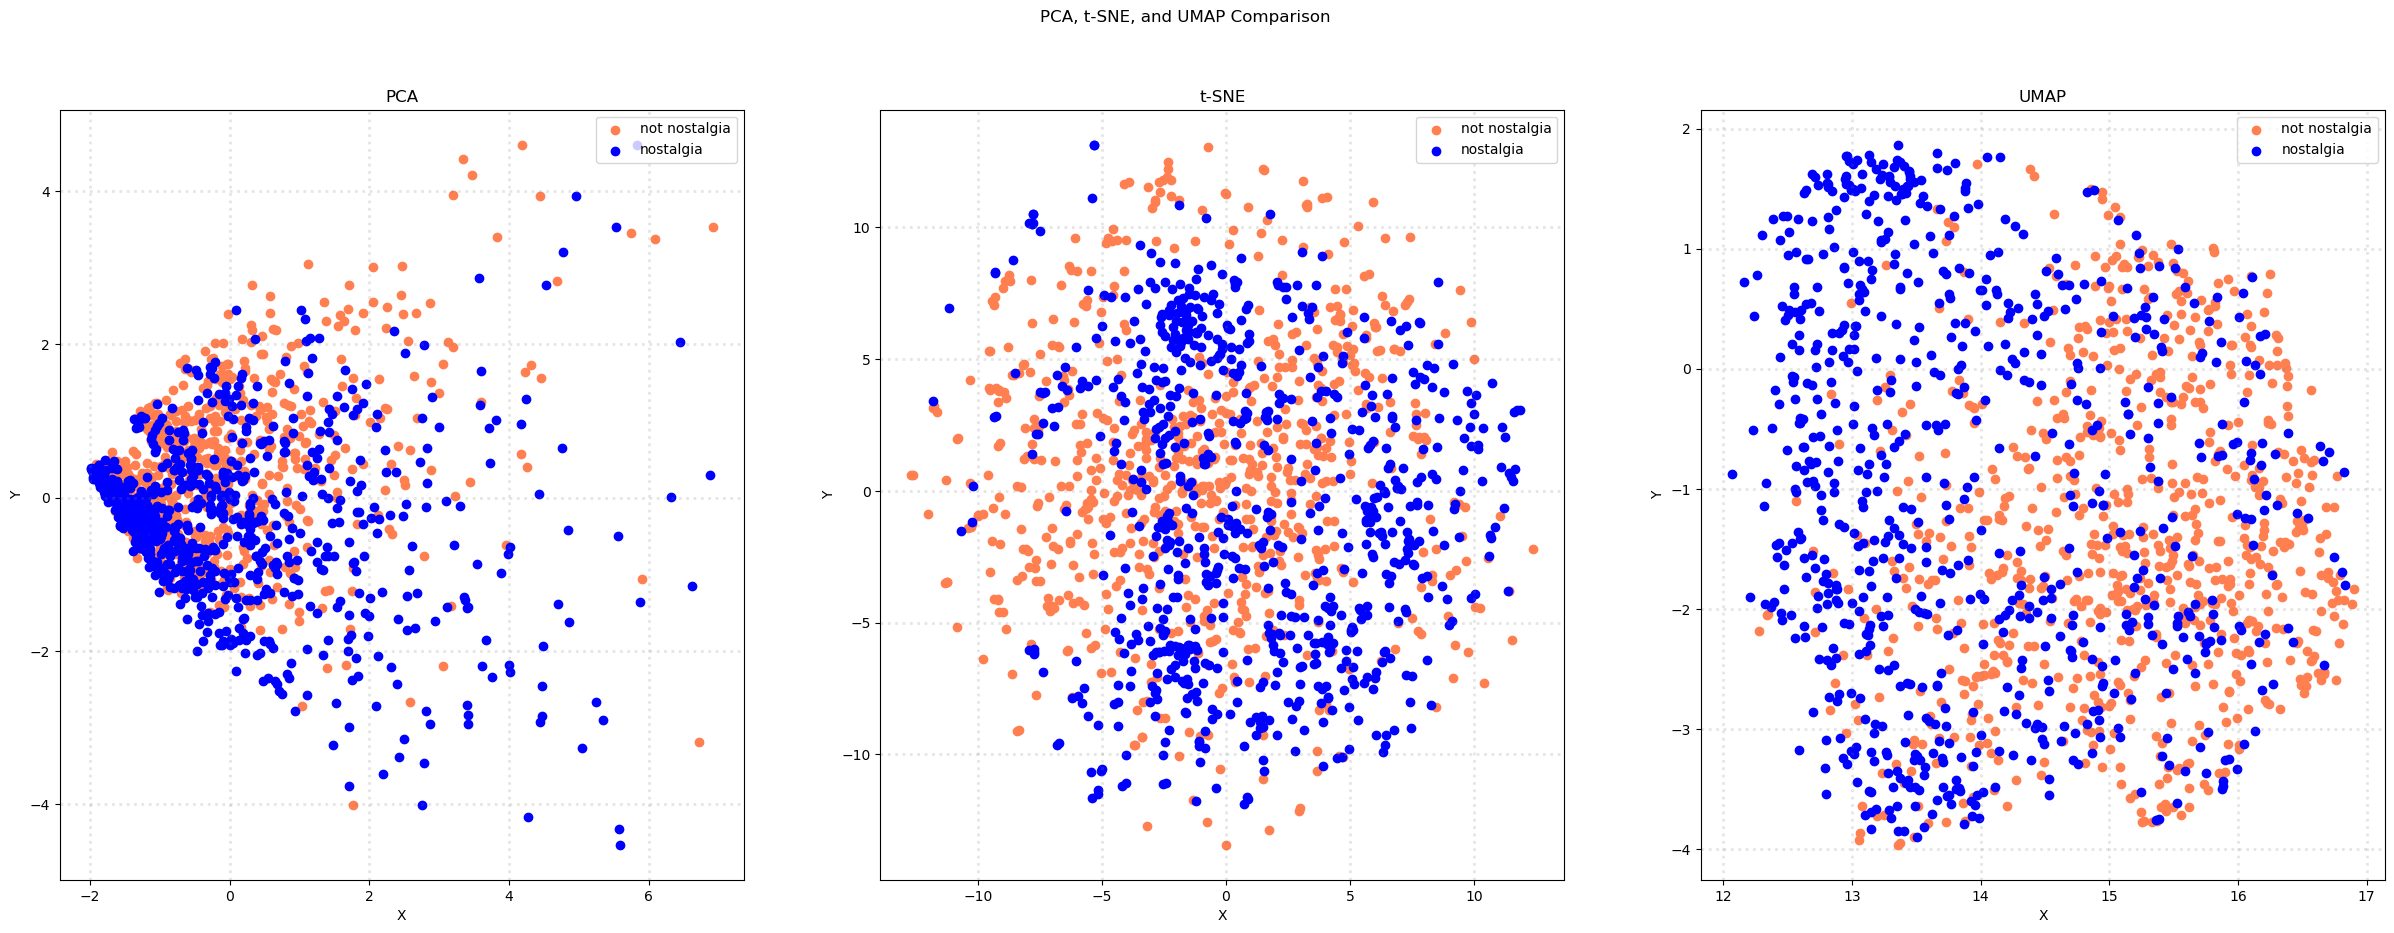

In [70]:
col = ['coral', 'blue']
categories = analysis['sentiment'].unique() 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

fig.suptitle('PCA, t-SNE, and UMAP Comparison')

def plot_scatter(ax, ana_reduced, title):
    for c, category in zip(col, categories):
        xs = ana_reduced[analysis['sentiment'] == category].T[0]
        ys = ana_reduced[analysis['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], ana_pca_aug, 'PCA')
plot_scatter(axes[1], ana_tsne_aug, 't-SNE')
plot_scatter(axes[2], ana_umap_aug, 'UMAP')
plt.show()

### Exercise 18

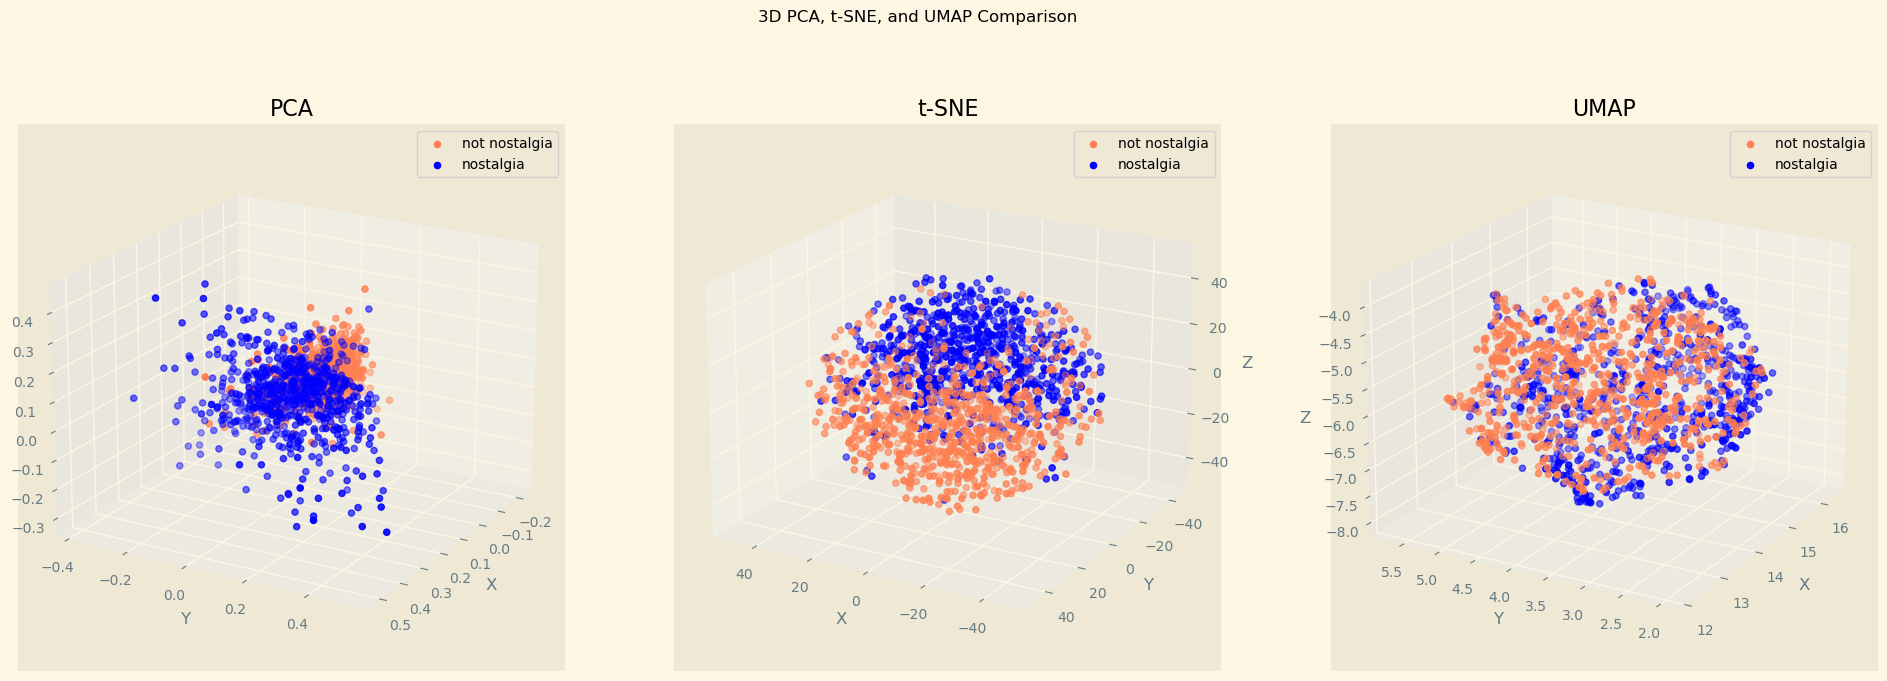

In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: 過濾出文字欄位並確認資料類型
X_text = analysis['comment'].dropna()          # 刪除任何 NaN 值
X_text = X_text.astype(str)           # 確保所有內容為字串型別

# Step 2: 使用 TfidfVectorizer 將文字向量化
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X_text)

# Step 3: 將向量化資料降維至 3 維
X_pca_aug = PCA(n_components=3).fit_transform(X_vectorized.toarray())
X_tsne_aug = TSNE(n_components=3).fit_transform(X_vectorized.toarray())
X_umap_aug = umap.UMAP(n_components=3).fit_transform(X_vectorized.toarray())

# 設定顏色和類別名稱
col = ['coral', 'blue', 'black', 'orange']
categories = analysis['sentiment'].unique()

# 創建 3D 散佈圖
fig = plt.figure(figsize=(24, 8))
fig.suptitle('3D PCA, t-SNE, and UMAP Comparison')

# 定義一個 3D 散點圖繪製函數
def plot_3d_scatter(ax, X_reduced, title, angle):
    for c, category in zip(col, categories):
        mask = (analysis['sentiment'] == category)
        xs = X_reduced[mask, 0]
        ys = X_reduced[mask, 1]
        zs = X_reduced[mask, 2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category)

    ax.view_init(elev=20, azim=angle)  # 設置視角
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')

# Step 4: 創建 3D 散佈圖，並從不同角度觀察
angles = [30, 120, 210]  # 設置三個不同的視角
X_reductions = [X_pca_aug, X_tsne_aug, X_umap_aug]
titles = ['PCA', 't-SNE', 'UMAP']

for i, (X_reduced, title) in enumerate(zip(X_reductions, titles)):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    plot_3d_scatter(ax, X_reduced, title, angles[i])

plt.show()

### Exercise 19

In [71]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
mlb = preprocessing.LabelBinarizer()
mlb.fit(analysis.sentiment)
analysis['bin_category'] = mlb.transform(analysis['sentiment']).tolist()
analysis[:5]

,sentiment,comment,unigrams,tokenized_comment,bin_category
0,not nostalgia,He was a singer with a golden voice that I lov...,"[He, was, a, singer, with, a, golden, voice, t...","{you, emotional, now,, but,, voice, in, age, c...",[1]
1,nostalgia,The mist beautiful voice ever I listened to hi...,"[The, mist, beautiful, voice, ever, I, listene...","{voice, was, angel, Never, listened, beautiful...",[0]
2,nostalgia,I have most of Mr. Reeves songs. Always love ...,"[I, have, most, of, Mr., Reeves, songs, ., Alw...","{smooth, simple, age, at, grew, was, it, grow,...",[0]
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...,"[30, day, leave, from, 1st, tour, in, Viet, Na...","{years, receive., you, Lou., the, served, can,...",[1]
4,nostalgia,listening to his songs reminds me of my mum wh...,"[listening, to, his, songs, reminds, me, of, m...","{played, him, listening, reminds, everyday, so...",[0]


Data Exploration

In [72]:
doc2transform_1 = []
random_record_1 = analysis.iloc[50]
random_record_1 = random_record_1['comment']
doc2transform_1.append(random_record_1)

doc2transform_2 = []
random_record_2 = analysis.iloc[60]
random_record_2 = random_record_2['comment']
doc2transform_2.append(random_record_2)

doc2transform_3 = []
random_record_3 = analysis.iloc[80]
random_record_3 = random_record_3['comment']
doc2transform_3.append(random_record_3)

In [73]:
print(doc2transform_1)
print(doc2transform_2)
print(doc2transform_3)

['If I remember correctly, this song came out after Mr. Reeves passed away. I was about 10 years old when the disc jockey said that the news just came over the wire that he died in a plane crash.']
['I have listened to Distant  Drums since my teens many years ago Jims  a awesome  singer  love his songs God bless  Jim , from Inverness']
['Love that beat, does anyone know who the drummer was on this classic?  I can???t find it! Thanks']


In [74]:
from sklearn.preprocessing import binarize

document_vector_count_1 = count_vect.transform(doc2transform_1)
document_vector_count_2 = count_vect.transform(doc2transform_2)
document_vector_count_3 = count_vect.transform(doc2transform_3)

document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.031435
Cosine Similarity using count bw 1 and 3: 0.250319
Cosine Similarity using count bw 2 and 3: 0.051709
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


C:\Users\HP\AppData\Local\Temp\ipykernel_18564\1433203154.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
C:\Users\HP\AppData\Local\Temp\ipykernel_18564\1433203154.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
C:\Users\HP\AppData\Local\Temp\ipykernel_18564\1433203154.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation.

Data Classification

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

analysis['bin_category'] = analysis['bin_category'].apply(lambda x: x[0] if isinstance(x, list) else x)
category_mapping = dict(analysis[['bin_category', 'sentiment']].drop_duplicates().values)
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]
X_train, X_test, y_train, y_test = train_test_split(tdm_df, analysis['sentiment'], test_size=0.3, random_state=42)

In [80]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8822222222222222

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.8286    0.9486    0.8845       214
not nostalgia     0.9463    0.8220    0.8798       236

     accuracy                         0.8822       450
    macro avg     0.8875    0.8853    0.8822       450
 weighted avg     0.8903    0.8822    0.8821       450



TF-IDF

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(analysis['comment'])  # 生成 TF-IDF 特徵矩陣
tfidf_features = tfidf_vect.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)
print(tfidf_df.head())

    00  000  045   07   10  100  10m   11  11th   12  ...  yours  yourself  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  ...    0.0       0.0   

   youth  youthful  youtube  yrs  yuo  yup  zealand  zulus  
0    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
1    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
2    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
3    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  
4    0.0       0.0      0.0  0.0  0.0  0.0      0.0    0.0  

[5 rows x 3730 columns]


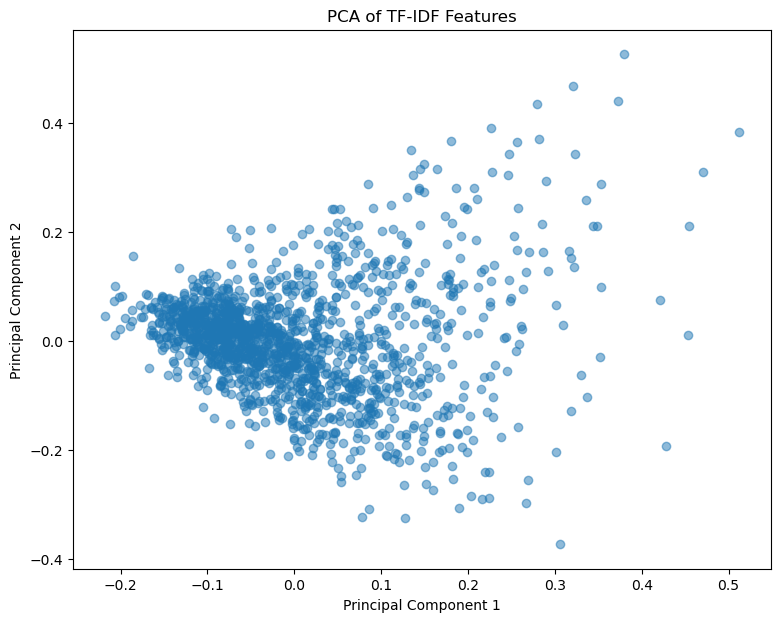

In [82]:
# 降維後TF_IDF資料的散佈圖
tfidf_pca = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(9, 7))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], alpha=0.5)
plt.title("PCA of TF-IDF Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

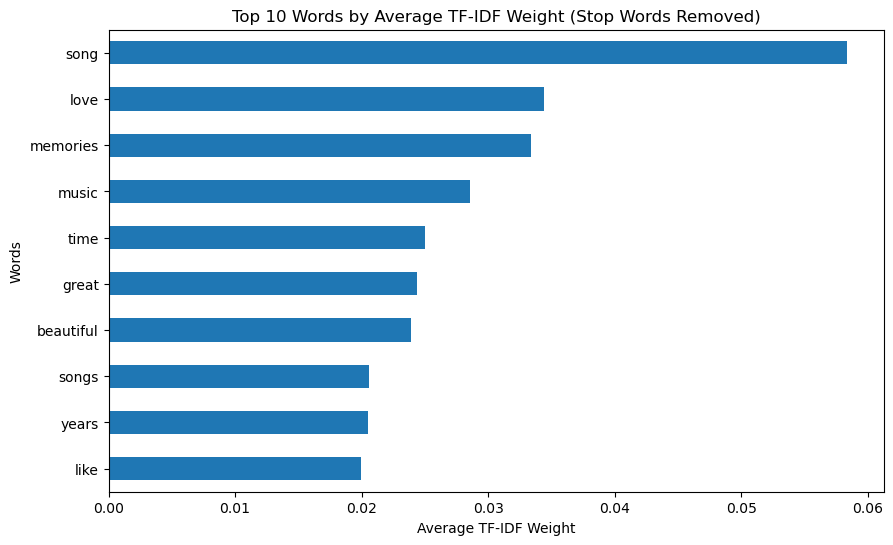

In [83]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(analysis['comment'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

top_n = 10
top_n_words = tfidf_df.mean().sort_values(ascending=False).head(top_n).index

tfidf_df[top_n_words].mean().sort_values().plot(kind='barh', figsize=(10, 6))
plt.title(f"Top {top_n} Words by Average TF-IDF Weight (Stop Words Removed)")
plt.xlabel("Average TF-IDF Weight")
plt.ylabel("Words")
plt.show()

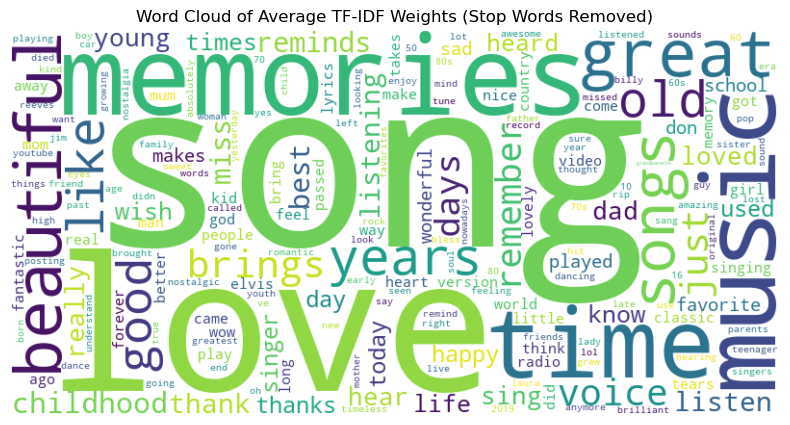

In [84]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_df.mean())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不顯示坐標軸
plt.title("Word Cloud of Average TF-IDF Weights (Stop Words Removed)")
plt.show()

In [85]:
# two new classifier

In [87]:
# TF-IDF for GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

# tfidf_matrix

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_matrix, analysis['sentiment'], test_size=0.2, random_state=42)

X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()

nb_classifier_tfidf = GaussianNB()
nb_classifier_tfidf.fit(X_train_tfidf_array, y_train)

y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf_array)

print("TF-IDF Features - Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf, target_names=target_names, digits=4))


TF-IDF Features - Accuracy: 0.6766666666666666

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.6308    0.8311    0.7172       148
not nostalgia     0.7619    0.5263    0.6226       152

     accuracy                         0.6767       300
    macro avg     0.6963    0.6787    0.6699       300
 weighted avg     0.6972    0.6767    0.6693       300



In [89]:
# TF-IDF for BernoulliNB()
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, analysis['sentiment'], test_size=0.2, random_state=42)

# 使用 BernoulliNB 訓練模型
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, y_train)

# 預測並評估
y_pred = bernoulli_nb.predict(X_test)

# 顯示精確度和分類報告
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8833333333333333

Classification Report:
                precision    recall  f1-score   support

    nostalgia       0.84      0.95      0.89       148
not nostalgia       0.94      0.82      0.88       152

     accuracy                           0.88       300
    macro avg       0.89      0.88      0.88       300
 weighted avg       0.89      0.88      0.88       300



In [92]:
# wf for BernoulliNB
texts = analysis['comment']
labels = analysis['sentiment']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=42)
vectorizer = CountVectorizer(binary=True)
X_train_tdm = vectorizer.fit_transform(X_train)
X_test_tdm = vectorizer.transform(X_test)

In [93]:
bnb_classifier = BernoulliNB()
bnb_classifier.fit(X_train_tdm, y_train)

BernoulliNB()

In [94]:
y_pred = bnb_classifier.predict(X_test_tdm)

print("Accuracy:", accuracy_score(y_test, y_pred))

target_names = ['nostalgia', 'not nostalgia']  # 根據你的類別名稱調整
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.9022222222222223

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.8696    0.9346    0.9009       214
not nostalgia     0.9364    0.8729    0.9035       236

     accuracy                         0.9022       450
    macro avg     0.9030    0.9037    0.9022       450
 weighted avg     0.9046    0.9022    0.9023       450



In [95]:
# Comment on the differences below:
# wf - multinomial / wf - bernoulli 
# tf-igf - gaussian

# 1.利用詞頻對 multinomial / Bernoulli NB進行訓練的差異:
    # MultinomialNB 能夠捕捉詞頻的影響，適合處理包含詞數量多的文本，對詞頻和文本長度更敏感
    # BernoulliNB 更加專注於詞是否出現，因此適合文本中詞彙數量相對穩定且重複少的情況
    # 推測因為該sentiment detection文本中詞彙數量較少，故在Bernoulli NB()訓練時表現較佳
# 2.利用TF-IDF對GaussianNB()進行訓練:
    # GaussianNB 適合用於連續型數據（即數值型變量）並假設每個特徵符合正態分佈 (適合典型的統計資料以及連續型數值特徵)
    # 由於TF-IDF 特徵是稀疏矩陣，更非均勻正態分佈，故在這次的訓練中表現效果有限(僅有7成accuracy)
# 3.利用TF-IDF對BernoulliNB()進行訓練:
    # 針對前述對於BernoulliNB()提及的特徵，使用 TF-IDF 時，雖然產生的特徵並非全是二元值，但比起使用GaussianNB()，已取得相對好的效果

Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent
 parts you noticed? How can you improve the Data preprocessing for these specific datasets?

##### 1. Inefficient part I noticed: 
A:

##### 2. How csn I improve the data preprocesising for the specific datasets:
A:
